In [27]:
####### NOT USING ANY OF THIS CODE - ROUGH NOTEBOOK FOR TEST PURPOSES AND REWRITING SOME CODE #########


import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, roc_auc_score





# Paths (edit these to your environment)
DATA_DIR = Path("/hpc/group/igvf/benchmarks/Kircher_et_al_2019")

PRED_FILES = {
    # "K562": "/hpc/home/rv103/igvf/revathy/models/K562_Scaled_15_MSELoss/predictions.tsv",
    "K562-CustomLoss": "/hpc/home/rv103/igvf/revathy/Blueplots/predictions/K562_Scaled_15_CustomLoss.tsv",
}

POS_THRESH = 1e-5  # MPRA significance threshold for positive label
STYLE = {
    # "K562": {"color": "blue", "linestyle": "--"},           # MSE (dashed)
    "K562-CustomLoss": {"color": "red", "linestyle": "-"},  # Custom (solid)
}


In [25]:
def read_pred_table(pred_file: str) -> pd.DataFrame:
    pred='log2(Pred)'
    relFC='ref_alt_FC'
    
    pred_vals = pd.read_csv(pred_file, sep="\t", index_col=False, usecols=[5])
    pred_vals[pred] = pred_vals.apply(lambda row: row/np.log(2))
    
    cols = ["cre_chrom", "cre_start", "cre_end",
        "bin_chrom", "bin_start", "bin_end",
        "allele_pos", "ref_allele", "allele"]

    pred_table = pd.read_csv(pred_file, sep="\t|:|=|-", index_col=False, header=None, skiprows=1,
                         usecols=[0, 1, 2, 3, 4, 5, 7, 9, 10], names=cols, engine="python")

    pred_table = pred_table.merge(pred_vals, left_index=True, right_index=True)

    refFC = pred_table.loc[pred_table["ref_allele"] == pred_table["allele"], [pred]]
    refFC = refFC.loc[refFC.index.repeat(4)].reset_index(drop=True)
    pred_table[relFC] = pred_table[pred] - refFC[pred]

    return(pred_table)



In [30]:


def read_kircher_mpra_data(data_dir: str | Path,
                              file_path_col: str = 'file_path') -> pd.DataFrame:
    """
    Reads MPRA (Kircher et al.) TSVs from a directory (recursively) and returns
    a pandas DataFrame with harmonized columns.

    Returns columns:
      - allele_pos  : Position - 1 (0-based)
      - chrom       : 'chr' + Chromosome
      - ref_allele  : Ref
      - alt_allele  : Alt
      - p_value     : P-Value
      - experiment  : extracted from filename (e.g., 'GRCh38_<EXPERIMENT>.tsv')
      - region_type : parent directory name of the file
      - region      : first token in `experiment` split by '-' or '.'
      - <file_path_col> (optional): absolute path to file

    Notes:
      - Filters for single-nucleotide Ref/Alt (length 1) and excludes deletions (Alt != '-').
      - Drops rows with nulls after processing.
      - Searches for files recursively: **/*.tsv
    """
    if isinstance(data_dir, str):
        data_dir = Path(data_dir)

    # Find all .tsv files recursively (handles region_type subfolders)
    tsv_files = glob.glob(str(data_dir / "**" / "*.tsv"), recursive=True)
    if not tsv_files:
        # Return an empty DataFrame with expected columns
        base_cols = [
            'allele_pos', 'chrom', 'ref_allele', 'alt_allele',
            'p_value', 'experiment', 'region_type', 'region'
        ]
        if file_path_col:
            base_cols.append(file_path_col)
        return pd.DataFrame(columns=base_cols)

    dfs = []
    for fp in tsv_files:
        df = pd.read_csv(fp, sep="\t", na_values=["NA"])
        # Ensure needed columns exist
        required = {'Chromosome', 'Position', 'Ref', 'Alt', 'P-Value'}
        missing = required - set(df.columns)
        if missing:
            # Skip files that don't match the schema
            continue

        # Single-nucleotide SNVs only, exclude deletions
        ref_len1 = df['Ref'].astype(str).str.len() == 1
        alt_len1 = df['Alt'].astype(str).str.len() == 1
        not_del  = df['Alt'] != '-'
        df = df[ref_len1 & alt_len1 & not_del].copy()

        # Derived fields
        df['allele_pos'] = df['Position'] - 1
        # Normalize Chromosome (avoid double 'chr' if already present)
        chrom_str = df['Chromosome'].astype(str).str.replace(r'^chr', '', regex=True)
        df['chrom'] = 'chr' + chrom_str

        df['ref_allele'] = df['Ref']
        df['alt_allele'] = df['Alt']
        df['p_value']    = df['P-Value']

        # Path-derived fields
        file_name = Path(fp).name
        # experiment from filename: GRCh38_<EXPERIMENT>.tsv
        m = re.search(r'GRCh38_(.*)\.tsv$', file_name)
        experiment = m.group(1) if m else Path(fp).stem
        df['experiment'] = experiment

        # region_type is the parent folder name
        df['region_type'] = Path(fp).parent.name

        # region is the first token before '-' or '.'
        df['region'] = re.split(r'[-.]', experiment)[0]

        if file_path_col:
            df[file_path_col] = str(Path(fp).resolve())

        # Drop original columns and nulls
        drop_cols = ['Ref', 'Alt', 'Position', 'Chromosome', 'P-Value']
        keep_drop = [c for c in drop_cols if c in df.columns]
        df = df.drop(columns=keep_drop).dropna()

        dfs.append(df)

    if not dfs:
        base_cols = [
            'allele_pos', 'chrom', 'ref_allele', 'alt_allele',
            'p_value', 'experiment', 'region_type', 'region'
        ]
        if file_path_col:
            base_cols.append(file_path_col)
        return pd.DataFrame(columns=base_cols)

    out = pd.concat(dfs, ignore_index=True)
    # Reorder columns
    cols = ['allele_pos', 'chrom', 'ref_allele', 'alt_allele',
            'p_value', 'experiment', 'region_type', 'region']
    if file_path_col:
        cols.append(file_path_col)
    # Keep any extra columns at the end (if the TSV had more)
    cols = [c for c in cols if c in out.columns] + [c for c in out.columns if c not in cols]
    return out[cols]


In [32]:
mpra_data = read_kircher_mpra_data(DATA_DIR)
mpra_data

,allele_pos,chrom,ref_allele,alt_allele,p_value,experiment,region_type,region,file_path,Tags,DNA,RNA,Value
0,109274651.0,chr1,G,A,0.015054,SORT1.2,Kircher_et_al_2019,SORT1,/hpc/group/igvf/benchmarks/Kircher_et_al_2019/...,366,41671,18013,0.11
1,109274651.0,chr1,G,C,0.329588,SORT1.2,Kircher_et_al_2019,SORT1,/hpc/group/igvf/benchmarks/Kircher_et_al_2019/...,102,9279,3390,-0.08
2,109274651.0,chr1,G,T,0.300428,SORT1.2,Kircher_et_al_2019,SORT1,/hpc/group/igvf/benchmarks/Kircher_et_al_2019/...,188,21034,8302,-0.06
3,109274652.0,chr1,A,C,0.434933,SORT1.2,Kircher_et_al_2019,SORT1,/hpc/group/igvf/benchmarks/Kircher_et_al_2019/...,35,4570,1762,-0.11
4,109274652.0,chr1,A,G,0.128980,SORT1.2,Kircher_et_al_2019,SORT1,/hpc/group/igvf/benchmarks/Kircher_et_al_2019/...,124,10446,4001,-0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78335,109274652.0,chr1,A,G,0.784267,SORT1-flip,Enhancers,SORT1,/hpc/group/igvf/benchmarks/Kircher_et_al_2019/...,66,3551,7818,0.02
78336,109274652.0,chr1,A,C,0.004026,SORT1-flip,Enhancers,SORT1,/hpc/group/igvf/benchmarks/Kircher_et_al_2019/...,126,8054,17840,-0.16
78337,109274651.0,chr1,G,T,0.324233,SORT1-flip,Enhancers,SORT1,/hpc/group/igvf/benchmarks/Kircher_et_al_2019/...,6,545,1563,0.25
78338,109274651.0,chr1,G,C,0.670255,SORT1-flip,Enhancers,SORT1,/hpc/group/igvf/benchmarks/Kircher_et_al_2019/...,15,2297,4294,0.07


In [34]:
kircher_nmut = len(mpra_data[['chrom', 'allele_pos', 'alt_allele']].drop_duplicates())

print(f"Total number of mutations with MPRA results: {kircher_nmut:,}")

Total number of mutations with MPRA results: 29,444


In [26]:
def _ensure_chr_prefix(s: str) -> str:
    s = str(s)
    return s if s.startswith("chr") else f"chr{s}"

def load_kircher_mpra_exact(data_dir: Path) -> pd.DataFrame:
    """
    Reads all GRCh38_*.tsv (or any *.tsv you like) that follow:
      Chromosome, Position, Ref, Alt, Tags, DNA, RNA, Value, P-Value
    Returns: chrom, pos, ref_allele, alt_allele, pval, label_bin
    """
    # adjust the pattern if your files are named differently
    tsv_paths = sorted(list(data_dir.glob("GRCh38_*.tsv")))
    if not tsv_paths:
        raise FileNotFoundError(f"No GRCh38_*.tsv files found under {data_dir}")

    dfs = []
    for p in tsv_paths:
        df = pd.read_csv(p, sep="\t", low_memory=False)
        needed = ["Chromosome", "Position", "Ref", "Alt", "P-Value"]
        missing = [c for c in needed if c not in df.columns]
        if missing:
            raise ValueError(f"{p} missing columns: {missing}")

        out = pd.DataFrame({
            "chrom": df["Chromosome"].astype(str).map(_ensure_chr_prefix),
            "pos": pd.to_numeric(df["Position"], errors="coerce"),
            "ref_allele": df["Ref"].astype(str),
            "alt_allele": df["Alt"].astype(str),
            "pval": pd.to_numeric(df["P-Value"], errors="coerce"),
        })
        dfs.append(out)

    mpra = pd.concat(dfs, ignore_index=True).dropna(subset=["chrom", "pos", "alt_allele", "pval"])
    mpra["label_bin"] = (mpra["pval"] <= POS_THRESH).astype(int)  # 1 = POS
    return mpra


In [10]:
# def load_predictions(pred_path: str) -> pd.DataFrame:
#     """
#     Reads predictions.tsv with columns:
#       ID, actualInterval, pos, ref, allele, prediction
#     Keeps only non-reference alleles and returns:
#       chrom, pos, alt_allele, score (= |prediction|)
#     Deduplicates with max per (chrom, pos, alt_allele).
#     """
#     df = pd.read_csv(pred_path, sep="\t")
#     needed = ["actualInterval", "pos", "ref", "allele", "prediction"]
#     missing = [c for c in needed if c not in df.columns]
#     if missing:
#         raise ValueError(f"{pred_path} missing columns: {missing}")

#     chrom = df["actualInterval"].astype(str).str.split(":", n=1, expand=True)[0].map(_ensure_chr_prefix)
#     pos = pd.to_numeric(df["pos"], errors="coerce")
#     ref = df["ref"].astype(str)
#     alt = df["allele"].astype(str)
#     pred = pd.to_numeric(df["prediction"], errors="coerce")

#     out = pd.DataFrame({
#         "chrom": chrom,
#         "pos": pos,
#         "ref_allele": ref,
#         "alt_allele": alt,
#         "score": pred.abs()
#     })

#     # exclude rows where allele == ref (true edits only)
#     out = out[out["alt_allele"] != out["ref_allele"]].dropna(subset=["chrom", "pos", "alt_allele", "score"])

#     # deduplicate
#     out = out.groupby(["chrom", "pos", "alt_allele"], as_index=False)["score"].max()
#     return out


In [11]:
def plot_roc_from_files(mpra_df: pd.DataFrame, pred_files: dict, title="ROC: K562_Scaled_15 (CustomLoss vs MSELoss)"):
    """
    Join predictions to MPRA labels by (chrom, pos, alt_allele) and plot both ROC curves.
    """
    plt.figure(figsize=(8, 7))

    for model_name, path in pred_files.items():
        if not os.path.exists(path):
            print(f"[warn] file not found for '{model_name}': {path}")
            continue

        preds = read_pred_table(path)
        merged = pd.merge(
            mpra_df[["chrom", "pos", "alt_allele", "label_bin"]],
            preds,
            on=["chrom", "pos", "alt_allele"],
            how="inner"
        ).dropna(subset=["label_bin", "score"])

        classes = set(merged["label_bin"].unique())
        if classes != {0, 1}:
            print(f"[warn] '{model_name}' lacks both classes after merge (classes={classes}); skipping.")
            continue

        y_true = merged["label_bin"].to_numpy()
        y_score = merged["score"].to_numpy()

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)

        style = STYLE.get(model_name, {"color": None, "linestyle": "-"})
        plt.plot(
            fpr, tpr,
            label=f"{model_name} (AUC={auc:.3f})",
            color=style["color"],
            linestyle=style["linestyle"],
            linewidth=2,
        )

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[warn] 'K562-CustomLoss' lacks both classes after merge (classes=set()); skipping.


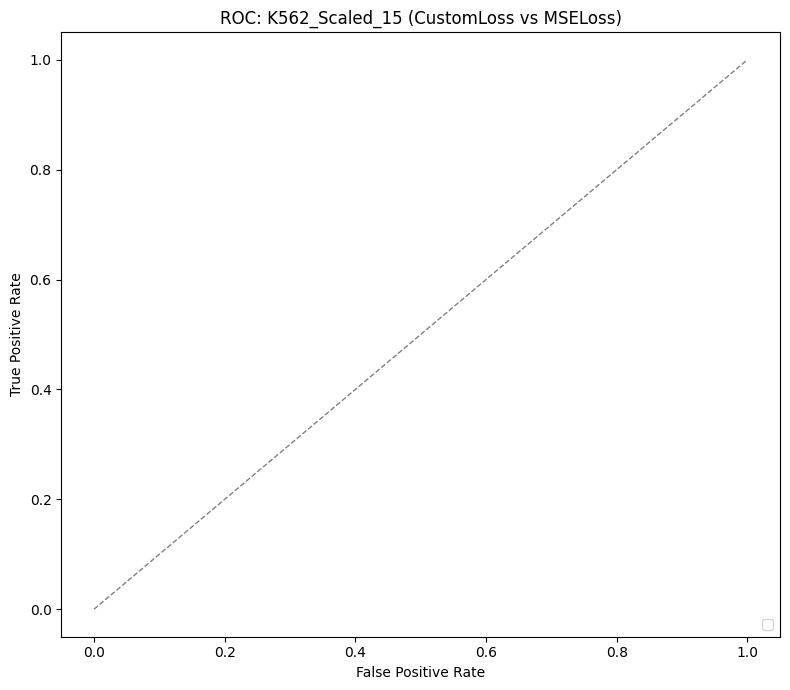

In [12]:
mpra_df = load_kircher_mpra_exact(DATA_DIR)
plot_roc_from_files(mpra_df, PRED_FILES)


In [23]:
import pandas as pd
import numpy as np

pred='log2(Pred)'
relFC='ref_alt_FC'

pred_file = '/hpc/home/rv103/igvf/revathy/Blueplots/predictions/Scaled_15/custom/K562_0.15-1.tsv'

pred_vals = pd.read_csv(pred_file, sep="\t", index_col=False, usecols=[5])
pred_vals[pred] = pred_vals.apply(lambda row: row/np.log(2))


cols = ["cre_chrom", "cre_start", "cre_end",
        "bin_chrom", "bin_start", "bin_end",
        "allele_pos", "ref_allele", "allele"]

pred_table = pd.read_csv(pred_file, sep="\t|:|=|-", index_col=False, header=None, skiprows=1,
                         usecols=[0, 1, 2, 3, 4, 5, 7, 9, 10], names=cols, engine="python")

pred_table = pred_table.merge(pred_vals, left_index=True, right_index=True)

refFC = pred_table.loc[pred_table["ref_allele"] == pred_table["allele"], [pred]]
refFC = refFC.loc[refFC.index.repeat(4)].reset_index(drop=True)
pred_table[relFC] = pred_table[pred] - refFC[pred]
pred_table



,cre_chrom,cre_start,cre_end,bin_chrom,bin_start,bin_end,allele_pos,ref_allele,allele,prediction,log2(Pred),ref_alt_FC
0,chr11,5227021,5227208,chr11,5226871,5227171,5227021,G,G,1.132595,1.633989,0.000000
1,chr11,5227021,5227208,chr11,5226871,5227171,5227021,G,C,1.107027,1.597102,-0.036886
2,chr11,5227021,5227208,chr11,5226871,5227171,5227021,G,A,1.090989,1.573965,-0.060024
3,chr11,5227021,5227208,chr11,5226871,5227171,5227021,G,T,1.096796,1.582342,-0.051647
4,chr11,5227021,5227208,chr11,5226872,5227172,5227022,G,G,1.134382,1.636568,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
39371,chr1,155301629,155301864,chr1,155301712,155302012,155301862,C,T,1.148805,1.657375,-0.013567
39372,chr1,155301629,155301864,chr1,155301713,155302013,155301863,T,G,1.183755,1.707797,0.039227
39373,chr1,155301629,155301864,chr1,155301713,155302013,155301863,T,C,1.193549,1.721927,0.053356
39374,chr1,155301629,155301864,chr1,155301713,155302013,155301863,T,A,1.187366,1.713007,0.044436


In [14]:
1.193549/np.log(2)

1.7219272233579814

In [ ]:
if convFC is not None:
    pred_vals[FC_name] = convFC(pred_vals[FC_name])
# get the remaining columns and merge
cols = ["cre_chrom", "cre_start", "cre_end",
        "bin_chrom", "bin_start", "bin_end",
        "allele_pos", "ref_allele", "allele"]
pred_table = pd.read_csv(pred_file, sep="\t|:|=|-", index_col=False, header=None,
                        usecols=[0, 1, 2, 3, 4, 5, 7, 9, 10], names=cols,
                        engine="python")
pred_table = pred_table.merge(pred_vals, left_index=True, right_index=True)
# compute relative activation of allele to ref
refFC = pred_table.loc[pred_table["ref_allele"] == pred_table["allele"], [FC_name]]
refFC = refFC.loc[refFC.index.repeat(4)].reset_index(drop=True)
pred_table[relFC_name] = pred_table[FC_name] - refFC[FC_name]
